<a href="https://colab.research.google.com/github/rizkyprofs/ML_DL/blob/main/DLWeek7_1imdb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, Bidirectional
from tensorflow.keras.layers import LSTM,BatchNormalization, GRU
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

# Load Dataset & Preparation

In [ ]:
# Parameter
num_words = 30000
maxlen = 500

# Load IMDB dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Konversi ke dictionary
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: np.float64(1.0), 1: np.float64(1.0)}


# RNN Model

RNN (Recurrent Neural Network) bekerja dengan menyimpan informasi dari time step sebelumnya:

### Rumus RNN:

**Hidden state:**
$$
h_t = \tanh(W_{xh}x_t + W_{hh}h_{t-1} + b_h)
$$

**Output:**
$$
y_t = W_{hy}h_t + b_y
$$

- \( x_t \): input pada waktu ke-t
- \( h_t \): hidden state pada waktu ke-t
- \( W_{xh}, W_{hh}, W_{hy} \): bobot jaringan
- \( b_h, b_y \): bias
- \( \tanh \): fungsi aktivasi nonlinear

In [ ]:
def build_model(hp):
    model = Sequential()

    # Embedding layer
    model.add(Embedding(
        input_dim=num_words,
        output_dim=hp.Int('embed_dim', 64, 256, step=64),
        input_length=maxlen
    ))

    # Fixed 2 Bidirectional RNN layers (but still tunable units & dropout)
    for i in range(2):
        return_seq = True if i == 0 else False
        model.add(Bidirectional(SimpleRNN(
            units=hp.Int(f'units_{i}', 32, 128, step=32),
            return_sequences=return_seq,
            dropout=hp.Float(f'dropout_rnn_{i}', 0.2, 0.5, step=0.1)
        )))
        model.add(BatchNormalization())

    # Fully connected layers (tunable jumlah dan unit)
    for j in range(hp.Int('num_dense_layers', 1, 2)):  # Tetap 1–2 layer
        model.add(Dense(
            units=hp.Int(f'dense_units_{j}', 64, 128, step=32),
            activation='relu'
        ))
        model.add(Dropout(hp.Float(f'dropout_dense_{j}', 0.2, 0.5, step=0.1)))

    # Output
    model.add(Dense(1, activation='sigmoid'))

    # Compile
    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd']),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

## Hyperparameter Tuning

In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='bidirectional_rnn_tuning'
)

tuner.search(
    x_train, y_train,
    epochs=5,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
)

best_model = tuner.get_best_models(num_models=1)[0]

Trial 5 Complete [00h 51m 08s]
val_accuracy: 0.5062000155448914

Best val_accuracy So Far: 0.8130000233650208
Total elapsed time: 03h 06m 57s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 44 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Final Training & Akurasi

In [ ]:
# Pastikan model sudah dikompilasi ulang jika diperlukan
best_model.compile(
    optimizer=best_model.optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Training lanjutan
history = best_model.fit(
    x_train, y_train,
    epochs=5,
    batch_size=64,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
    class_weight=class_weights
)

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 286s 886ms/step - accuracy: 0.9154 - loss: 0.2178 - val_accuracy: 0.8066 - val_loss: 0.4847
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 317s 870ms/step - accuracy: 0.9544 - loss: 0.1326 - val_accuracy: 0.7910 - val_loss: 0.7433
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 329s 894ms/step - accuracy: 0.9743 - loss: 0.0772 - val_accuracy: 0.7876 - val_loss: 0.7192
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 323s 896ms/step - accuracy: 0.9832 - loss: 0.0491 - val_accuracy: 0.7984 - val_loss: 0.8254


782/782 ━━━━━━━━━━━━━━━━━━━━ 89s 113ms/step
Akurasi: 0.8093
Presisi: 0.8247
Recall: 0.7855
F1-Score: 0.8046
AUC: 0.8930


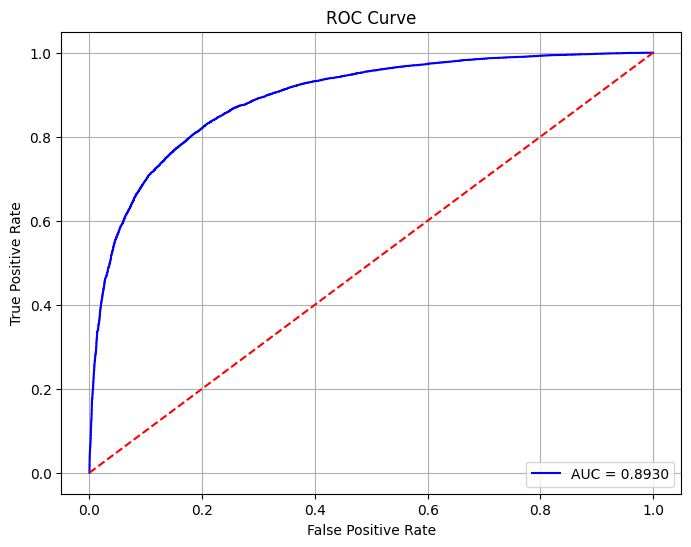

In [ ]:
# Evaluasi akhir pada data test
y_pred_prob = best_model.predict(x_test)  # Prediksi probabilitas
y_pred = (y_pred_prob > 0.5).astype(int)  # Ambil kelas berdasarkan threshold 0.5

# Menghitung metrik
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

print(f"Akurasi: {acc:.4f}")
print(f"Presisi: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

# Menghitung ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], color='r', linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

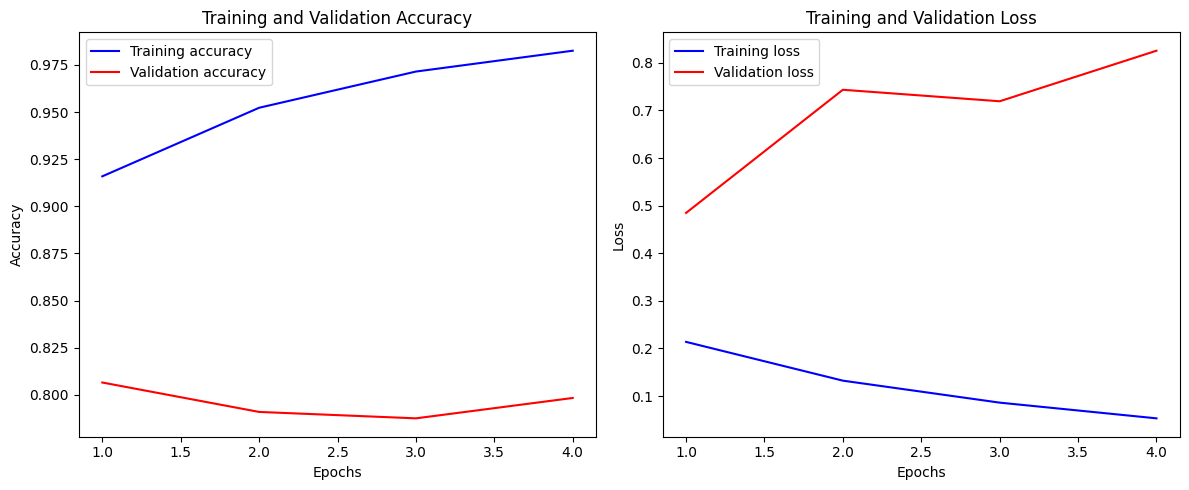

In [ ]:
def plot_training_history(history):
    # Mengambil data dari history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)  # Membuat range untuk epoch

    # Plotting Akurasi
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()  # Untuk memperbaiki layout agar tidak tumpang tindih
    plt.show()

# Panggil fungsi untuk memvisualisasikan grafik
plot_training_history(history)

Metrik Evaluasi

### Accuracy
$$
\text{Accuracy} = \frac{\text{True Positives + True Negatives}}{\text{Total Samples}}
$$

### Precision
$$
\text{Precision} = \frac{TP}{TP + FP}
$$

### Recall
$$
\text{Recall} = \frac{TP}{TP + FN}
$$

### F1-Score
$$
F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

### AUC (Area Under Curve)
Mengukur area di bawah kurva ROC. Semakin besar, semakin baik model membedakan antara kelas.

---

## 📈 ROC Curve
ROC (Receiver Operating Characteristic) menunjukkan trade-off antara True Positive Rate (TPR) dan False Positive Rate (FPR):

- TPR = Recall
- FPR = $\( \frac{FP}{FP + TN} \)$

Kurva ROC ideal berada di pojok kiri atas (TPR tinggi, FPR rendah).